# Markerless Pose Tracking

We've talked a lot about extracting neural signals from ephys and ophys measurements, but what comes next? One of the fundamental goals of systems neuroscience is to understand the relationship between neural activity and behavioral outputs. To that end, we need to quantify  and model not only neural activity but animals' behavior as well. 

The study of natural behavior is called **ethology** {cite}`Tinbergen1963-fg`. With advances in deep learning, the field is undergoing a computational revival {cite}`Anderson2014-lg`. The once tedious process of labeling video data to track body posture and annotate behaviors has been largely automated by machine learning methods, which are well-suited to the task {cite}`Branson2009-mz, Machado2015-yi, Mathis2018-uz, Graving2019-fq, pereira2022sleap, Wu2020-fi, Bala2020-ch`. At the intersection of computational neuroscience and computational ethology is the (predictably named) emerging field of **computational neuroethology** {cite}`Datta2019-ji`.

This chapter develops the basic methods underlying most markerless pose tracking systems.  There are a few key ideas. First, we can cast pose tracking &mdash; i.e. the task of labeling keypoints of interest in video frames, like an animals paws, snout, and tail, and tracking them over time &mdash; as a **supervised learning** problem. Given a few labeled frames, we can train a classifier to predict the keypoint locations in new frames.  Second, such classifiers require surprisingly few training examples, particularly when they are given features from networks that have been pre-trained on similar tasks. For example, deep neural networks trained for image classification on very large datasets like ImageNet may not immediately solve pose tracking problems, but the features they've learned for classifying cats and dogs may still be useful for tracking paws and snouts.  Using a neural network trained on one task to jump-start a model for a similar task is called **transfer learning**. 

We'll start with a simple logistic regression model for pose tracking and show how it can be implemented with a convolutional neural network (CNN). Then we'll show how the same ideas can be generalized to pre-trained CNNs for image classification, like very deep residual networks {cite}`He2016-rp`. 

## Supervised learning

In supervised learning problems, our data consists of a set of tuples $\{(\mathbf{x}_n, y_n)\}_{n=1}^N$ where $\mathbf{x}_n$ are the **inputs** and $y_n$ are the **outputs**. Contrast this with the spike sorting and calcium deconvolution problems, which we framed as unsupervised matrix factorization problems.

A simple way to frame the pose tracking problem as a supervised learning problem is to chop each image frame into **patches** and then assign each patch a binary **label** to indicate whether or not the patch contains a specific key point (e.g. "left paw"). Then we can train a binary **classifier** to predict the labels given the image patches. Of course, we usually want to track multiple key points at once, and we could simply train separate classifiers for each one. Ideally, the trained classifiers will **generalize** to new image patches from new video frames, giving us predictions about which patches contain which keypoints. Then, in post-processing, we can determine the most likely configuration of key points in future frames, using the classifiers' predictions.

:::{figure} images/07_pose_tracking/paw_classifier.png
---
name: paw_track
---
A simple way to do pose tracking is to carve each video frame into small patches and label them as positive or negative examples of a key point. Then train a classifier to predict the label for new patches.
This figure was adapted from fig. 1B of {cite:t}`Machado2015-yi`
:::

## Logistic regression

Let $\mathbf{x}_n \in \mathbb{R}^P$ be the $n$-th image patch, flattened into a vector of $P$ pixels. Let $y_n \in \{0,1\}$ be a binary label specifying whether the key point of interest is present in that frame. 

In **logistic regression**, we model the conditional distribution of the label given the image as,

$$
p(y_n \mid \mathbf{x}_n) = \mathrm{Bern}\big( \sigma(\mathbf{w}^\top \mathbf{x}_n) \big)
$$

where $\mathbf{w} \in \mathbb{R}^P$ are the **weights** for each pixel, and $\sigma: \mathbb{R} \mapsto (0, 1)$ is the **logistic function**


```{admonition} The Bernoulli distribution
The [**Bernoulli distribution**](https://en.wikipedia.org/wiki/Bernoulli_distribution) is a distribution over binary variables $y \in \{0,1\}$ with probability $p \in [0,1]$. Its pmf can be written as,

$$
\mathrm{Bern}(y; p) = p^{y} \, (1-p)^{(1-y)}
$$
```

```{admonition} The logistic (sigmoid) function

The [**logistic (aka sigmoid) function**](https://en.wikipedia.org/wiki/Sigmoid_function) is a map from the reals to the interval $(0,1)$. It is defined as,

$$
\sigma(a) = \frac{1}{1 + e^{-a}} = \frac{e^a}{1 + e^a}
$$

It asymptotes at $\lim_{a \to -\infty} \sigma(a) = 0$ and $\lim_{a \to \infty} \sigma(a) = 1$.  It is plotted below.

Interestingly, the logistic function is symmetric in that,

$$
1 - \sigma(a) = \frac{1}{1+e^a} = \sigma(-a).
$$

Its derivative is,

$$
\begin{align*}
\sigma'(a) = \frac{e^a}{(1+e^a)^2} = \left( \frac{e^a}{1+e^a}\right) \left( \frac{1}{1+e^a}\right) = \sigma(a) \sigma(-a).
\end{align*}
$$

The derivative is positive (i.e., the logistic function is monotonically increasing) and attains its maximum at $\sigma'(0) = \tfrac{1}{4}$. 

```

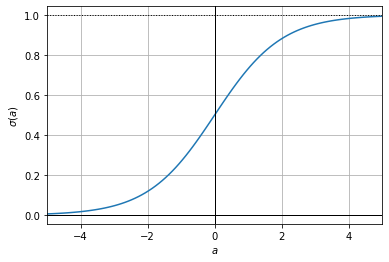

In [9]:
import torch
import matplotlib.pyplot as plt

aa = torch.linspace(-5, 5, 100)
plt.plot(aa, torch.sigmoid(aa))
plt.axhline(0, color='k', lw=1)
plt.axhline(1, color='k', ls=':', lw=1)
plt.axvline(0, color='k', lw=1)
plt.grid("True")
plt.xlim(-5, 5)
plt.xlabel(r"$a$")
_ = plt.ylabel(r"$\sigma(a)$")

## Optimization

Our goal is to estimate the weights $\mathbf{w}_{\mathsf{MLE}}$ that maximize the log likelihood of the training data, or equivalently minimize the negative log likelihood. Unlike most of the problems we've encountered thus far, we won't have a closed form solution for the weights, even if we try to do coordinate ascent. Instead we'll have to turn to more general optimization strategies like gradient descent and Newton's method. This is a good opportunity to introduce a few of these tools and some of the key concepts.

### Setup

Let $\mathbf{X} \in \mathbb{R}^{N \times P}$ denote the matrix of inputs (with rows $\mathbf{x}_n^\top$) and $\mathbf{y} = (y_1, \ldots, y_N) \in \{0,1\}^N$ denote the vector of output labels. The **negative** log likelihood is,

$$
\begin{align*}
\mathcal{L}(\mathbf{w}) &= -\log p(\mathbf{y} \mid \mathbf{w}, \mathbf{X}) \\
&= -\sum_{n=1}^N \log p(y_n \mid \mathbf{w}, \mathbf{x}_n) \\
&= -\sum_{n=1}^N \log \mathrm{Bern}(y_n; \sigma(\mathbf{w}^\top \mathbf{x}_n)) \\
&= -\sum_{n=1}^N \left(y_n \mathbf{w}^\top \mathbf{x}_n - \log(1 + e^{\mathbf{w}^\top \mathbf{x}_n}) \right)
\end{align*}
$$

### The gradient with respect to the weights
The gradient with respect to $\mathbf{w}$ is,

$$
\begin{align*}
\nabla \mathcal{L}(\mathbf{w}) 
&= -\sum_{n=1}^N \left( y_n \mathbf{x}_n - \frac{e^{\mathbf{w}^\top \mathbf{x}_n}}{1 + e^{\mathbf{w}^\top \mathbf{x}_n}} \mathbf{x}_n\right) \\
&= -\sum_{n=1}^N \big(y_n - \sigma(\mathbf{w}^\top \mathbf{x}_n)\big) \, \mathbf{x}_n
\end{align*}
$$

Unfortunately, this is a nonlinear function of $\mathbf{w}$ (due to the logistic function), and when we set to zero and try to solve for the weights, we find there is no closed-form solution.


### The negative log likelihood is convex

While there may not be a closed-form solution, the problem is not necessarily all that hard to solve. It turns out the negative log likelihood is a **convex function** of the weights &mdash; i.e., it looks like an upward facing bowl &mdash; so we can solve it with off-the-shelf optimization tools. 

To show that the objective function is convex, it suffices to show that it is twice-differentiable and its [**Hessian**](https://en.wikipedia.org/wiki/Hessian_matrix) (the matrix of second-order partial derivatives) is positive semi-definite (has eigenvalues $\geq 0$).

The Hessian of the negative log likelihood is,

$$
\begin{align*}
\nabla^2 \mathcal{L}(\mathbf{w})
&= \sum_{n=1}^N \sigma'(\mathbf{w}^\top \mathbf{x}_n) \mathbf{x}_n \mathbf{x}_n^\top 
\end{align*}
$$

where $\sigma'(\mathbf{w}^\top \mathbf{x}_n)$ is the derivative of the logistic function (see above) evaluated at $\mathbf{w}^\top \mathbf{x}_n$.

Since this a sum of outer products ($\mathbf{x}_n \mathbf{x}_n^\top$) with positive coefficients ($\sigma(\mathbf{w}^\top \mathbf{x}_n)$), the Hessian is positive semi-definite. 

```{admonition} Matrix derivatives
:class: tip

It takes some practice to become familiar with the rules of matrix calculus. I recommend the first chapters of [The Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) {cite}`petersen2008matrix` for an introduction. 
```

### Gradient descent

Since the the negative log likelihood is convex (equivalently, the log likelihood is concave), we have a host of tools at our disposal for maximum likelihood estimation. We don't need CVXPy to solve this problem (like we did for the previous chapter). Here, we can simply perform **gradient descent**. 

Let $\mathbf{w}_0$ denote our initial setting of the weights. Gradient descent is an iterative algorithm that produces a sequence of weights $\mathbf{w}_0, \mathbf{w}_1, \ldots$ that (under certain conditions) converges to a local optimum of the objective. Since the objective is convex, all local optima are global optima. The idea is straightforward, on each iteration we update the weights by taking a step in the direction of the gradient,

$$
\begin{align*}
\mathbf{w}_{i+1} &= \mathbf{w}_i - \alpha_i \nabla \mathcal{L}(\mathbf{w}_i)
\end{align*}
$$

where $\alpha_i \in \mathbb{R}_+$ is the **learning rate** (aka step size) on iteration $i$, and $\nabla \mathcal{L}(\mathbf{w}_i)$ is the gradient of the objective evaluated at the current weights $\mathbf{w}_i$. 

```{admonition} Convergence of gradient descent
:class: dropdown

When $\mathcal{L}$ is convex and $\nabla \mathcal{L}$ is [**Lipschitz continuous**](https://en.wikipedia.org/wiki/Lipschitz_continuity), and when the learning rates satisfy certain conditions (e.g., they are set by a [**backtracking line search**](https://en.wikipedia.org/wiki/Backtracking_line_search)), then gradient descent will converge to a local optimum. When the objective is convex, all local optima are global optima, so then gradient descent is guaranteed to find a global solution.
```

### Newton's method

Gradient descent uses first-order information (i.e., the gradient of the objective at the current weights) to determine the descent direction. We can obtain faster convergence rates using **second-order** information (i.e., the Hessian of the objective). 

The idea is to minimize a quadratic approximation of the objective given by a Taylor approximation around the current weights,

$$
\begin{align*}
\mathcal{L}(\mathbf{w}) 
&\approx \mathcal{L}(\mathbf{w}_i) + (\mathbf{w} - \mathbf{w}_i)^\top \nabla \mathcal{L}(\mathbf{w}_i) 
+ \frac{1}{2} (\mathbf{w} - \mathbf{w}_i)^\top \nabla^2 \mathcal{L}(\mathbf{w}_i) (\mathbf{w} - \mathbf{w}_i).
\end{align*}
$$

The minimum of this quadratic approximation has a closed form solution,

$$
\mathbf{w}_{i+1} = \mathbf{w}_i + \nabla^2 \mathcal{L}(\mathbf{w}_i)^{-1} \nabla \mathcal{L}(\mathbf{w}_i).
$$

Here, the descent direction is given by the inverse-Hessian times the gradient, $\nabla^2 \mathcal{L}(\mathbf{w}_i)^{-1} \nabla \mathcal{L}(\mathbf{w}_i)$. 

```{warning}
Note that Newton's method assumes that the Hessian is invertible, which is almost surely the case for logistic regression with many data points. We can ensure invertibility by adding a multivariate normal prior on the weights, as we will introduce below.
```

Newton's method can be unstable in practice. A simple fix is to use the same descent direction, but that to vary the step size $\alpha_i$,

$$
\mathbf{w}_{i+1} = \mathbf{w}_i + \alpha_i \nabla^2 \mathcal{L}(\mathbf{w}_i)^{-1} \nabla \mathcal{L}(\mathbf{w}_i).
$$

For example, the step-size can be set to $\alpha_i < 1$ to implement _damped_ Newton's method, or it can be determined by a backtracking line search. 

### Iteratively reweighted least squares (IRLS)

The weight updates simplify nicely when we substitute in the form of the gradient and Hessian for logistic regression. Note that they can be written in matrix form as,

$$
\begin{align*}
\nabla \mathcal{L}(\mathbf{w}) &= -\mathbf{X}^\top \big(\mathbf{y} - \sigma(\mathbf{X} \mathbf{w}) \big) \\
\nabla^2 \mathcal{L}(\mathbf{w}) &= \mathbf{X}^\top \mathbf{S} \mathbf{X}
\end{align*}
$$

where

$$
\mathbf{S} = \mathrm{diag}\left([\sigma'(\mathbf{w}^\top \mathbf{x}_1), \ldots, \sigma'(\mathbf{w}^\top \mathbf{x}_N)] \right)
$$

is a diagonal **scaling (aka weighting) matrix**. Note that the scale factors are all positive since $\sigma'(a) > 0$. 

Substituting these forms in and rearranging yield,

$$
\begin{align*}
\mathbf{w}_{i+1} 
&= \mathbf{w}_i + \big(\mathbf{X}^\top \mathbf{S} \mathbf{X}\big)^{-1} \mathbf{X}^\top \big( \mathbf{y} - \sigma(\mathbf{X} \mathbf{w}) \big) \\
&= \big(\mathbf{X}^\top \mathbf{S} \mathbf{X}\big)^{-1} \mathbf{X}^\top \mathbf{S} \tilde{\mathbf{y}},
\end{align*} 
$$

where 

$$
\tilde{\mathbf{y}} = \mathbf{X} \mathbf{w}_i + \mathbf{S}^{-1} \big(\mathbf{y} - \sigma(\mathbf{X} \mathbf{w}_i) \big).
$$

In other words, the standard Newton method update can be viewed as the solution to a [**weighted least squares**](https://en.wikipedia.org/wiki/Weighted_least_squares) problem with weights $\mathbf{S}$ and targets $\tilde{\mathbf{y}}$ that depend on the current weights $\mathbf{w}_i$. Viewed this way, we see that Newton's method for logistic regression is equivalent to an algorithm called [**iteratively reweighted least squares (IRLS)**](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares). 

### Computational complexity

```{admonition} Exercise
:class: tip

Show that the computational complexity of gradient descent is $\mathcal{O}(NP)$ whereas the complexity of Newton's method is $\mathcal{O}(NP^2 + P^3)$. 
```

### Scaling up

Though it converges faster, Newton's method quickly becomes intractable for large $N$ and $P$. For large $N$, even gradient descent becomes costly. There are a few ways to speed up computation:

- **Quasi-Newton methods** like [**BFGS**](https://en.wikipedia.org/wiki/BFGS_method) replace the exact Hessian with an approximation and side-step the explicit matrix inversion.
- [**Stochastic gradient descent (SGD)**](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) uses subsets of data (a.k.a. _minibatches_) to approximate the gradient. Under fairly general conditions, it converges to a local optimum.
- **Momentum** is often used in conjunction with SGD to keep the descent direction from changing too rapidly. This can address some of the limitations of regular gradient descent as well, e.g., where the updates overshoot in poorly conditioned problems. Related methods like Nesterov's accelerated gradient (see {cite:t}`sutskever2013importance`) can achieve second-order convergence rates using first-order information (under certain conditions).
- Still, SGD (with momentum) requires **setting a learning rate**. Modern machine learning packages like [`torch.optim`](https://pytorch.org/docs/stable/optim.html) implement a number of optimizers that automatically tune the learning rates, like **AdaGrad** {cite}`duchi2011adaptive`, **RMSProp** {cite}`rmsprop`, and **Adam** {cite}`kingma2014adam`. 

## Pose tracking by convolution

Remember we started by treating each data point as patch $\mathbf{x}_n$ and a binary label $y_n$ specifying whether a specific key point (e.g. "left paw") is present. Of course, in practice we want to classify all the patches in an image in parallel, and we want to predict more than one type of key point.

Let $\mathbf{X}_n \in \mathbb{R}^{P_H \times P_W}$ denote the $n$-th image and $\mathbf{Y}_{n,k} \in \{0,1\}^{P_H \times P_W}$ denote the binary mask of where in the $k$-th key point is in the $n$-th image. Both are $P_H$ pixels in height and $P_W$ pixels wide. Assume the patches are $P_h \times P_w$ in size, with $P_h < P_H$ and $P_w < P_W$.  Finally, ket $\mathbf{W}_k \in \mathbb{R}^{P_h \times P_w}$ denote the weights for the $k$-th key point. 

We can think of each image as having $P_H \cdot P_W$ patches and corresponding labels, one centered on each pixel. In our simple logistic regression model, each patch's label is modeled as a conditionally independent Bernoulli random variable,

$$
\begin{align*}
p(\mathbf{Y} \mid \mathbf{X}, \mathbf{W}) 
&= \prod_{n=1}^N \prod_{k=1}^K \prod_{i=1}^{P_H} \prod_{j=1}^{P_W} \mathrm{Bern}(y_{n,k,i,j}; \sigma(a_{n,k,i,j}))
\end{align*}
$$

where $a_{n,k,i,j} \in \mathbb{R}$ is the **activation** for that specific image, key point, and pixel. The activations are given by a **2D cross-correlation**,

$$
\begin{align*}
a_{n,k,i,j} 
&= \sum_{d=1}^{P_h} \sum_{d'=1}^{P_w} w_{k,d,d'} x_{n,i+d-\frac{P_h}{2},j+d'-\frac{P_w}{2}} \\
&= [\mathbf{X_n} \star \mathbf{W}_k]_{i,j}.
\end{align*}
$$

In fact, the activations for an entire batch of $N$ images and $K$ key points (i.e., output channels) can be computed in a single call to [`F.conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html), with the appropriate padding. In lab, we'll make use of the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) class, which encapsulates the weights of a 2D convolution layer and makes it easy to train such models.


### Convolutional neural networks

Framed this way, we can view the logistic regression model as a **one-layer convolutional neural network (CNN)**. This view also suggests an obvious direction for improvement. The activations of the logistic regression model are **linear functions** of the pixels. In practice, a good key point detector may need **nonlinear features** of the images. Moreover, the features necessary to predict one keypoint (e.g., the left paw) may be similar to those needed for another (e.g., the right). 

Convolutional neural networks allow both nonlinear feature learning and feature sharing between outputs. The idea is straightforward: stack multiple convolutional layers on top of each other, feeding the output of one as the input to the next. 

**Residual networks (ResNets)** enable very deep CNNs to be stably trained by adding **skip connections** whereby the input is fed straight to the output of a layer, thereby allowing the convolution to capture the difference (i.e., residual) between the input and output.

These notes will not comprehensively cover CNNs and ResNets. Instead, please consult the many great online resources, like {cite:t}`Goodfellow-et-al-2016` and the PyTorch [tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

## Next Up

- Transfer Learning 
- Structured priors
